In [234]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import FeatureUnion
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
           'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

### Importing dataset`

In [179]:
housing = pd.read_csv('housing.data.txt', sep="\s+", header=None, names = columns)

### important functions

In [180]:
def split_feature_target(df):
    train_set, test_set = train_test_split(df, test_size = 0.2, random_state=42)
    x_train =  train_set.drop('MEDV', axis=1)
    y_train =  train_set['MEDV']
    x_test  =  test_set.drop('MEDV', axis=1)
    y_test  =  test_set['MEDV']
    return x_train, y_train, x_test, y_test

def error(expected, predicted):
    rms = np.sqrt(mean_squared_error(expected, predicted))
    r2 = r2_score(expected, predicted)
    return 'rms error = {}, r2 score = {}'.format(rms, r2)
def error1(expected, predicted):
    rms = np.sqrt(mean_squared_error(expected, predicted))
    r2 = r2_score(expected, predicted)
    return rms, r2

# funtion to select columns
def column_selector(y):
    def columns(x):
        return x[y].values
    return columns
# Plot observed vs. predicted and predicted vs. residuals
def myplots(y_pre, y_train):
    plt.figure(figsize=(15,7))
    plt.subplot(121)
    plt.scatter(y_train, y_pre)
    plt.xlabel('observed')
    plt.ylabel('predicted')
    plt.title('observed vs. predicted')
    plt.subplot(122)
    plt.scatter(y_pre, y_train - y_pre)
    plt.xlabel('predicted')
    plt.ylabel('residuals')
    plt.title('predicted vs. residuals')

In [181]:
%run 'CategoricalEncoder.py'

### splitting training and testing data set

In [182]:
x_train, y_train, x_test, y_test = split_feature_target(housing)
cat_features = ['CHAS']
num_features= list(x_train.drop(['CHAS'], axis=1))

### pipeline for features transformation

In [183]:
# pipeline for numerical columns
numeric_cols_pipeline = make_pipeline(FunctionTransformer(func=column_selector(num_features), validate=False),
                                      StandardScaler())
categoric_cols_pipeline = make_pipeline(FunctionTransformer(func=column_selector(cat_features), validate=False),
                                        CategoricalEncoder(encoding='onehot-dense'))

# joining pipelines
full_pipeline = FeatureUnion(transformer_list=[('numerical_pipeline', numeric_cols_pipeline),
                                               ('categorical_pipeline', categoric_cols_pipeline)
                                              ])

In [184]:
train_features = full_pipeline.fit_transform(x_train)

### Linear Regression

In [185]:
from sklearn.linear_model import LinearRegression

In [186]:
lin = LinearRegression()
lin.fit(train_features, y_train)
y_pre = lin.predict(train_features)
error(y_train, y_pre)

'rms error = 4.6520331848801675, r2 score = 0.7508856358979673'

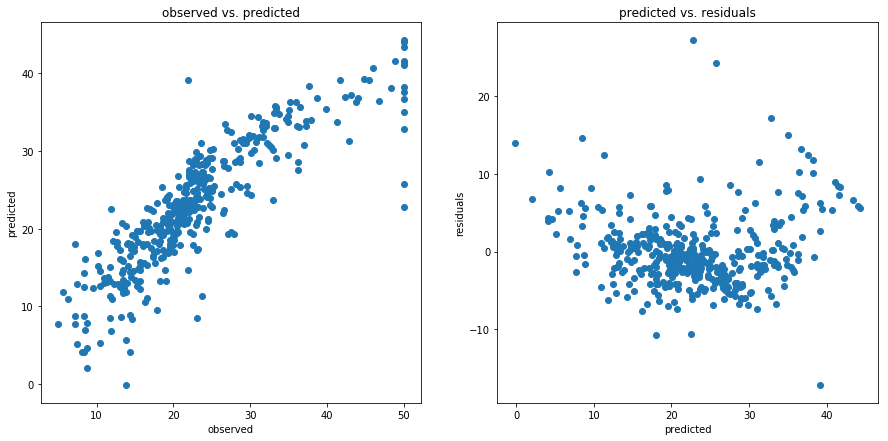

In [187]:
myplots(y_pre, y_train)

#### SGDRegressor

In [188]:
from sklearn.linear_model import SGDRegressor

Text(0.5,1,'max_iter vs RMSE')

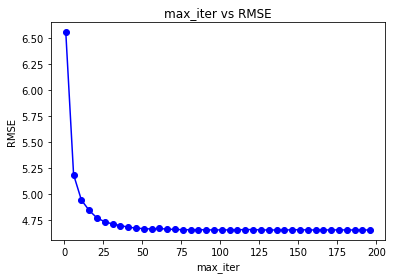

In [189]:
para= []
rms = []
for i in np.arange(1, 200, 5):
    sgd = SGDRegressor(max_iter=i)
    sgd.fit(train_features, y_train)
    y_pre = sgd.predict(train_features)
    x, y = error1(y_train, y_pre)
    para.append(i)
    rms.append(x)
plt.plot(para, rms, 'b-o')
plt.xlabel('max_iter')
plt.ylabel('RMSE')
plt.title('max_iter vs RMSE')

In [190]:
sgd = SGDRegressor(max_iter=100)
sgd.fit(train_features, y_train)
y_pre = sgd.predict(train_features)
error(y_train, y_pre)

'rms error = 4.658191133684925, r2 score = 0.7502256884090353'

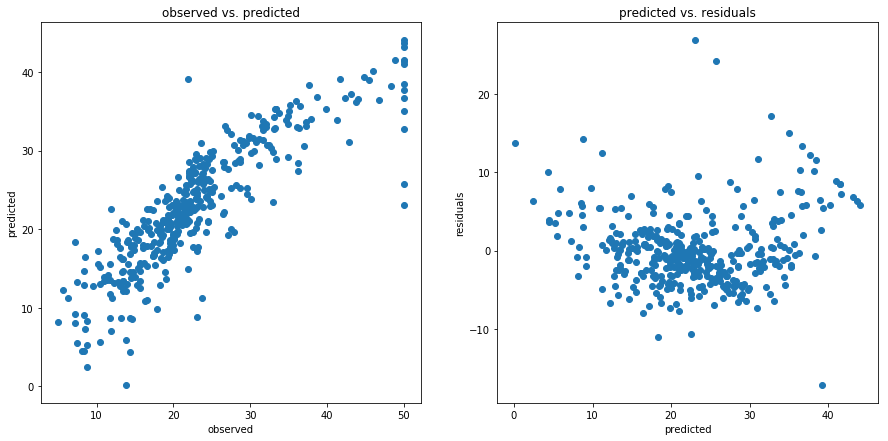

In [191]:
myplots(y_pre, y_train)

### Lasso for feature selection

In [192]:
from sklearn.linear_model import Lasso

In [193]:
para= []
rms = []
for i in np.arange(0.00001, 0.01, 0.001):
    lasso = Lasso(alpha=i)
    lasso.fit(train_features, y_train)
    y_pre = lasso.predict(train_features)
    x, y = error1(y_train, y_pre)
    para.append(i)
    rms.append(x)

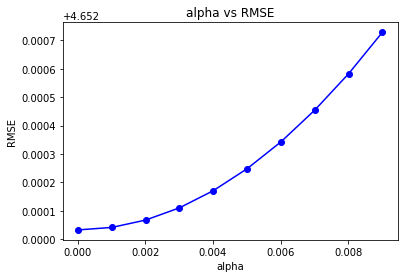

In [194]:
plt.plot(para, rms, 'b-o')
plt.xlabel('alpha')
plt.ylabel('RMSE')
x =plt.title('alpha vs RMSE')

In [195]:
lasso = Lasso(alpha=0.00001)
lasso.fit(train_features, y_train)
y_pre = lasso.predict(train_features)

In [196]:
error(y_train, y_pre)

'rms error = 4.652033185739029, r2 score = 0.750885635805984'

#### Important features

In [197]:
pd.Series(lasso.coef_).sort_values(ascending=False).head(6)

4     3.145248e+00
7     2.251235e+00
10    1.129559e+00
1     6.962208e-01
2     2.779797e-01
13    3.548911e-14
dtype: float64

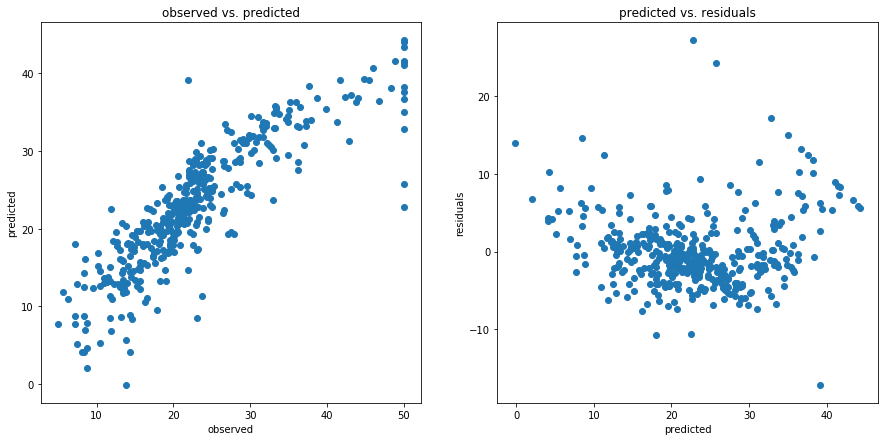

In [198]:
myplots(y_pre, y_train)

### Polynomial Regression

In [199]:
from sklearn.preprocessing import PolynomialFeatures
ply = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LinearRegression())

ply.fit(train_features, y_train)

y_pre = ply.predict(train_features)
error(y_train, y_pre)

'rms error = 2.2653686314144257, r2 score = 0.9409267415598885'

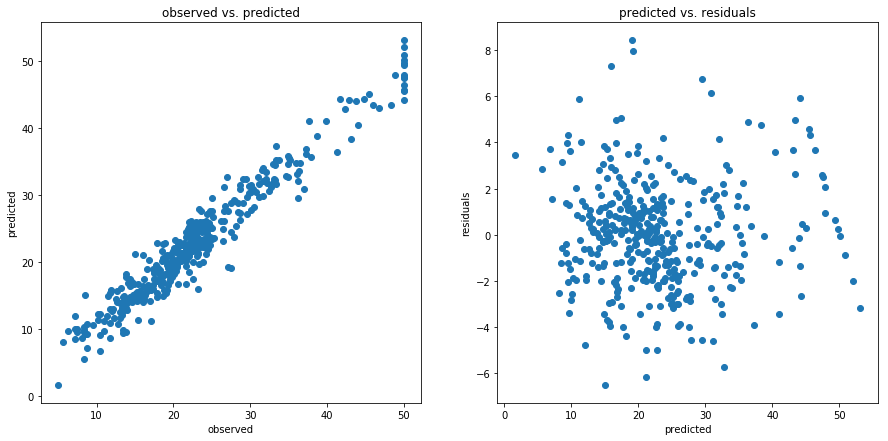

In [200]:
myplots(y_pre, y_train)

### Regularization using Lasso

In [201]:
ply = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), Lasso(alpha=1))

ply.fit(train_features, y_train)

y_pre = ply.predict(train_features)
error(y_train, y_pre)

'rms error = 4.506985041761444, r2 score = 0.7661779869277413'

In [202]:
ply_fear = PolynomialFeatures(degree=2, include_bias=False).fit_transform(train_features)

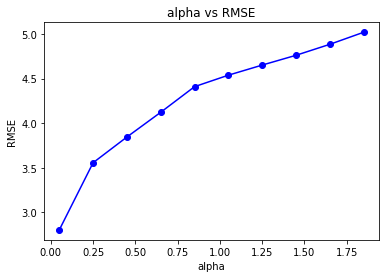

In [203]:
para= []
rms = []

for i in np.arange(0.05, 2, 0.2):
    ls = Lasso(alpha=i)
    ls.fit(ply_fear, y_train)
    y_pre = ls.predict(ply_fear)
    x , y = error1(y_train, y_pre)
    para.append(i)
    rms.append(x)

plt.plot(para, rms, 'b-o')
plt.xlabel('alpha')
plt.ylabel('RMSE')
x =plt.title('alpha vs RMSE')

In [204]:
lass = Lasso(alpha=0.25)
ply = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), lass)

ply.fit(train_features, y_train)

y_pre = ply.predict(train_features)
error(y_train, y_pre)

'rms error = 3.5563820744918755, r2 score = 0.8544105226487182'

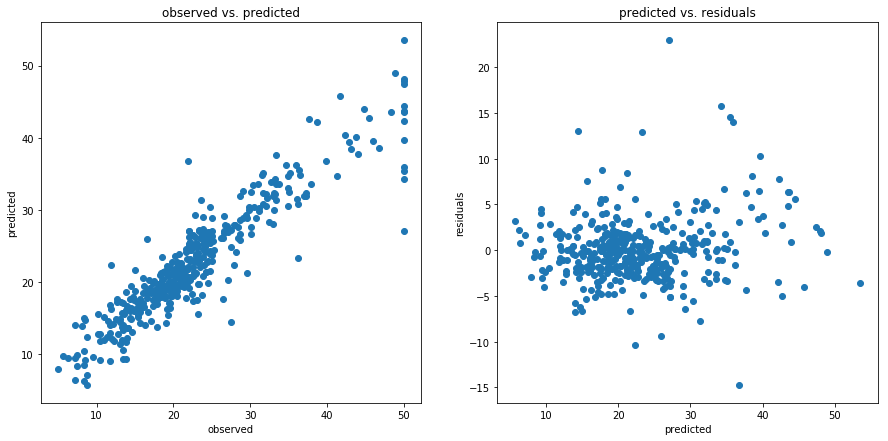

In [205]:
myplots(y_pre, y_train)

### Regularization using Ridge

In [206]:
from sklearn.linear_model import Ridge

In [207]:
para= []
rms = []
for i in np.arange(0.1, 1, 0.1):
    ridge = Ridge(alpha=i)
    ridge.fit(train_features, y_train)
    y_pre = ridge.predict(train_features)
    x, y = error1(y_train, y_pre)
    para.append(i)
    rms.append(x)

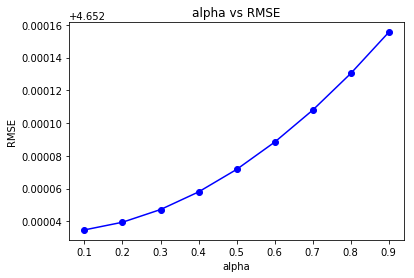

In [208]:
plt.plot(para, rms, 'b-o')
plt.xlabel('alpha')
plt.ylabel('RMSE')
x = plt.title('alpha vs RMSE')

In [209]:
ply = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), Ridge(alpha=100))

ply.fit(train_features, y_train)

y_pre = ply.predict(train_features)
error(y_train, y_pre)

'rms error = 3.1311476210922504, r2 score = 0.8871451446299582'

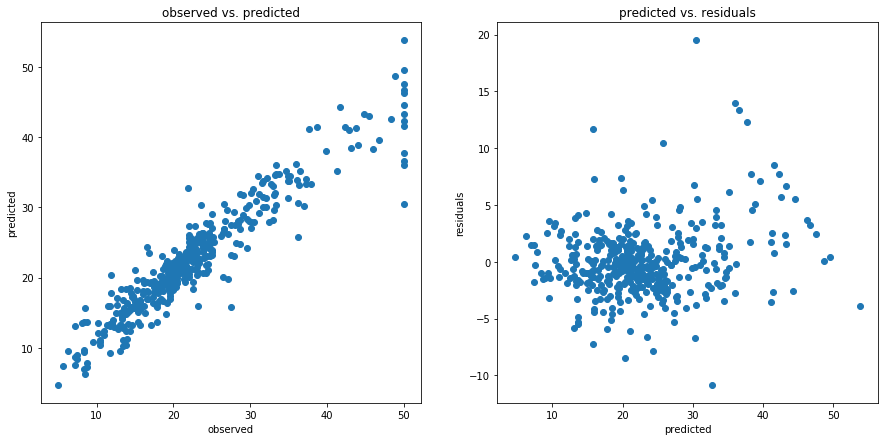

In [210]:
myplots(y_pre, y_train)

### PCA for feature selection

In [211]:
from sklearn.decomposition import PCA

In [212]:
pca = PCA()

In [213]:
pca.fit(train_features)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [214]:
cumsum = np.cumsum(pca.explained_variance_ratio_)

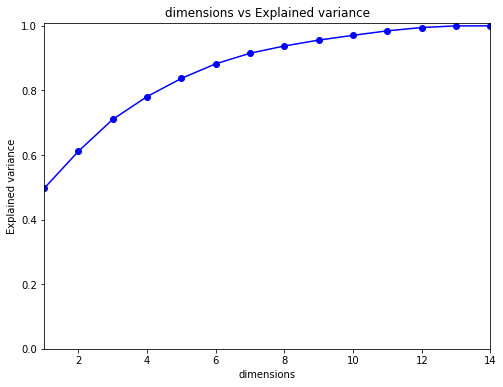

In [215]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(cumsum))+1, cumsum, 'bo-')
plt.xlabel('dimensions')
plt.ylabel('Explained variance')
plt.xlim(1,14)
plt.ylim(0,1.01)
x = plt.title('dimensions vs Explained variance')

In [216]:
d = np.argmax(cumsum >= 0.95) + 1
d

9

In [217]:
para= []
rms = []
for i in np.arange(1,15 , 1):
    pca = PCA(n_components=i)
    pca.fit(train_features)
    features_pca = pca.transform(train_features)
    lin = LinearRegression()
    lin.fit(features_pca, y_train)
    y_pre = lin.predict(features_pca)
    x, y = error1(y_train, y_pre)
    para.append(i)
    rms.append(x)

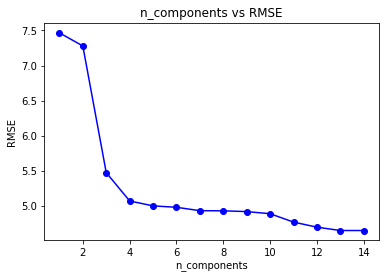

In [218]:
plt.plot(para,rms,'b-o')
plt.xlabel('n_components')
plt.ylabel('RMSE')
x = plt.title('n_components vs RMSE')

In [219]:
pca = PCA(n_components=0.95)
pca.fit(train_features)
features_pca = pca.transform(train_features)
lin = LinearRegression()
lin.fit(features_pca, y_train)
y_pre = lin.predict(features_pca)
error(y_train, y_pre)

'rms error = 4.92139014645006, r2 score = 0.7212025786379138'

### Features selecting using RandomForest

In [220]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(random_state=42, max_depth=3)
rf_reg.fit(train_features, y_train)
pd.Series(rf_reg.feature_importances_).sort_values(ascending=False).head(6)

4     0.526784
11    0.353999
6     0.059488
0     0.021379
3     0.009129
8     0.008524
dtype: float64

### GradientBoostingRegressor

In [221]:
from sklearn.ensemble import  GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)

In [222]:
para= []
rms = []
for i in np.arange(1,300 , 10):
    gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=i, learning_rate=0.5, random_state=42)
    gbrt.fit(features_pca, y_train)
    y_pre = gbrt.predict(features_pca)
    x, y = error1(y_train, y_pre)
    para.append(i)
    rms.append(x)

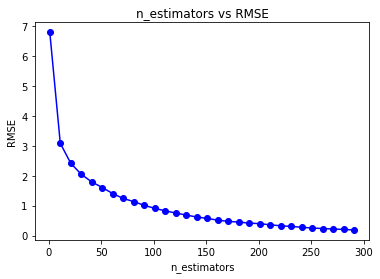

In [223]:
plt.plot(para,rms,'b-o')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
x = plt.title('n_estimators vs RMSE')

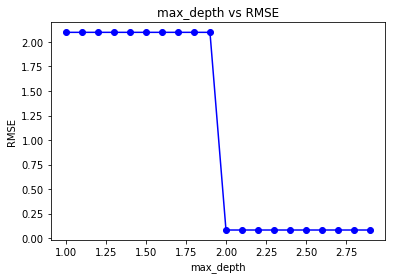

In [224]:
para= []
rms = []
for i in np.arange(1,3, 0.1):
    gbrt = GradientBoostingRegressor(max_depth=i, n_estimators=400, learning_rate=0.5, random_state=42)
    gbrt.fit(features_pca, y_train)
    y_pre = gbrt.predict(features_pca)
    x, y = error1(y_train, y_pre)
    para.append(i)
    rms.append(x)

plt.plot(para,rms,'b-o')
plt.xlabel('max_depth')
plt.ylabel('RMSE')
x = plt.title('max_depth vs RMSE')

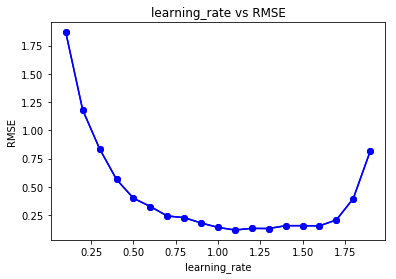

In [225]:
para= []
rms = []
for i in np.arange(0.1,2, 0.1):
    gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=i, random_state=42)
    gbrt.fit(features_pca, y_train)
    y_pre = gbrt.predict(features_pca)
    x, y = error1(y_train, y_pre)
    para.append(i)
    rms.append(x)

plt.plot(para,rms,'b-o')
plt.plot(para,rms,'b-o')
plt.xlabel('learning_rate')
plt.ylabel('RMSE')
x = plt.title('learning_rate vs RMSE')

In [226]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(features_pca, y_train)
y_pre = gbrt.predict(features_pca)
error(y_train, y_pre)

'rms error = 4.066526760332127, r2 score = 0.8096466908986968'

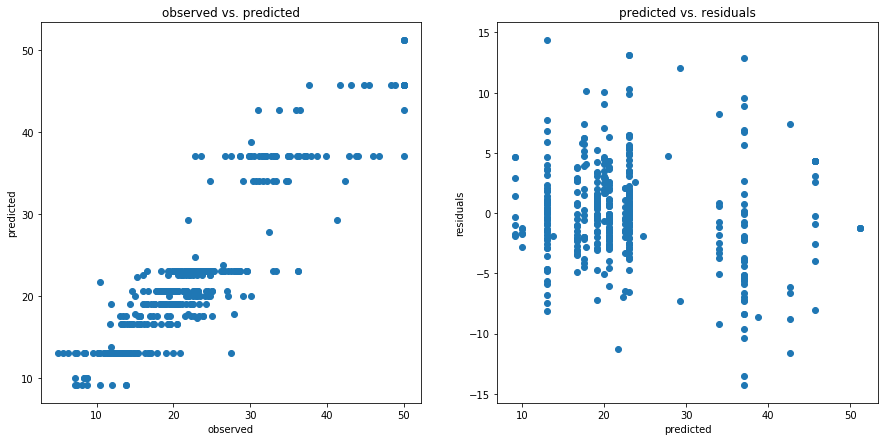

In [227]:
myplots(y_pre, y_train)

In [228]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt.fit(features_pca, y_train)
y_pre = gbrt.predict(features_pca)
error(y_train, y_pre)

'rms error = 1.8665348233694714, r2 score = 0.959896215721558'

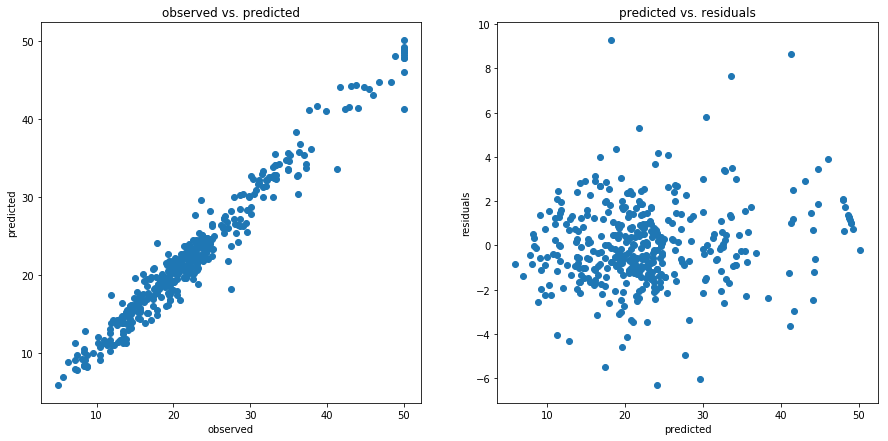

In [229]:
myplots(y_pre, y_train)

### Support vector Regression

In [230]:
from sklearn.svm import SVR

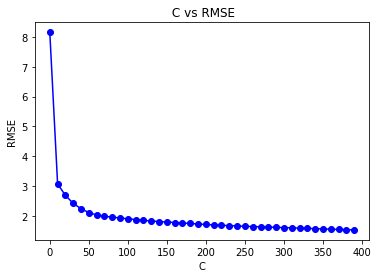

In [231]:
para= []
rms = []
for i in np.arange(0.1,400, 10):
    svr = SVR(C=i)
    svr.fit(features_pca, y_train)
    y_pre = svr.predict(features_pca)
    x, y = error1(y_train, y_pre)
    para.append(i)
    rms.append(x)
plt.plot(para,rms,'b-o')
plt.xlabel('C')
plt.ylabel('RMSE')
x = plt.title(' C vs RMSE')

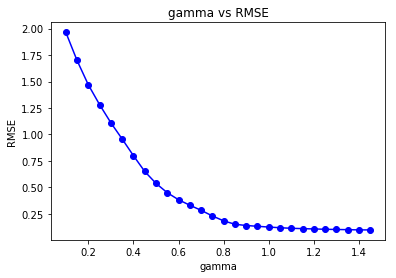

In [232]:
para= []
rms = []
for i in np.arange(0.1, 1.5,0.05):
    svr = SVR(kernel="rbf", gamma=i, C=100)
    svr.fit(features_pca, y_train)
    y_pre = svr.predict(features_pca)
    x, y = error1(y_train, y_pre)
    para.append(i)
    rms.append(x)
plt.plot(para,rms,'b-o')
plt.xlabel('gamma')
plt.ylabel('RMSE')
x = plt.title('gamma vs RMSE')

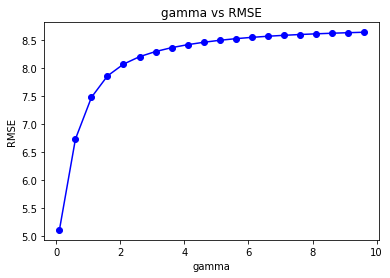

In [233]:
para= []
rms = []
for i in np.arange(0.1, 10,0.5):
    svr = SVR(kernel="rbf", gamma=i, C=1)
    svr.fit(features_pca, y_train)
    y_pre = svr.predict(features_pca)
    x, y = error1(y_train, y_pre)
    para.append(i)
    rms.append(x)
plt.plot(para,rms,'b-o')
plt.xlabel('gamma')
plt.ylabel('RMSE')
x = plt.title('gamma vs RMSE')